In [1]:
from sklearn import datasets
from scipy.stats import norm, t, levene, ttest_ind
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np

# T-tests: one-tailed and two-tailed examples

This notebook demonstrates how to perform and interpret both one-tailed and two-tailed t-tests using real-world datasets. It covers:

- Formulating hypotheses
- Validating assumptions (normality, independence, equal variances)
- Performing Welch’s t-test when variances differ
- Interpreting results with p-values and confidence

## Introduction

The t-distribution is a probability distribution that resembles the normal distribution but has heavier tails. This means it accounts for greater uncertainty, especially with small sample sizes or when the population variance is unknown. As the sample size (degrees of freedom) increases, the t-distribution approaches the normal distribution.

t-test's can be used to determine if there is a significant difference between the means of two groups. It is useful when the population standard deviation is unknown and the sample size is small. The t-test relies on the t-distribution to calculate the probability (p-value) of observing the data assuming the null hypothesis is true.

The plot below compares the standard normal distribution (in blue) with t-distributions for 3 degrees of freedom (red dashed) and 10 degrees of freedom (green dotted):
- The t-distribution with 3 degrees of freedom has noticeably heavier tails than the normal distribution. This reflects increased uncertainty due to the smaller sample size.
- The t-distribution with 10 degrees of freedom is closer to the normal curve, illustrating how the t-distribution converges to the normal as sample size grows.
- These heavier tails mean that extreme values are more probable under the t-distribution, making it more conservative when sample sizes are small.

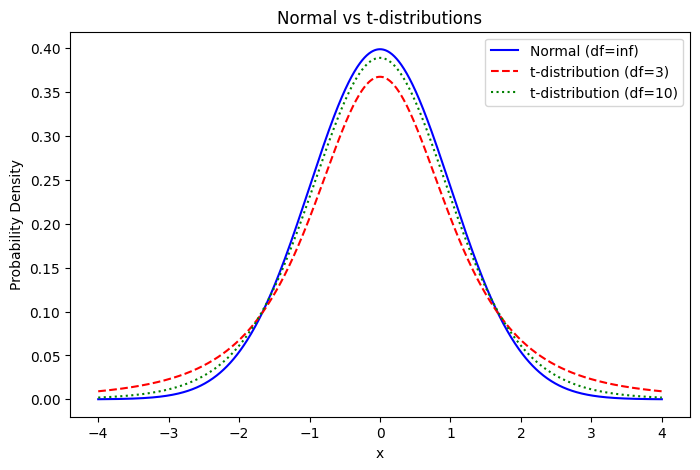

In [2]:

x = np.linspace(-4, 4, 1000)

# normal
normal_pdf = norm.pdf(x, 0, 1)

# t-distributions with different degrees of freedom
t_dof3 = t.pdf(x, df=3)
t_dof10 = t.pdf(x, df=10)

plt.figure(figsize=(8, 5))

plt.plot(x, normal_pdf, label='Normal (df=inf)', color='blue')
plt.plot(x, t_dof3, label='t-distribution (df=3)', color='red', linestyle='--')
plt.plot(x, t_dof10, label='t-distribution (df=10)', color='green', linestyle=':')

plt.title('Normal vs t-distributions')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.legend()

## One tailed t-test

We will use `diabetes` for an example. The target is a "quantitative measure of disease progression one year after baseline" We will examine if there is a difference in the target based of off `sex`.

In [3]:
dataset = datasets.load_diabetes(as_frame=True, scaled=False)
df = dataset.frame
df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,59.0,2.0,32.1,101.0,157.0,93.2,38.0,4.0,4.8598,87.0,151.0
1,48.0,1.0,21.6,87.0,183.0,103.2,70.0,3.0,3.8918,69.0,75.0
2,72.0,2.0,30.5,93.0,156.0,93.6,41.0,4.0,4.6728,85.0,141.0
3,24.0,1.0,25.3,84.0,198.0,131.4,40.0,5.0,4.8903,89.0,206.0
4,50.0,1.0,23.0,101.0,192.0,125.4,52.0,4.0,4.2905,80.0,135.0


Let's create a boxplot to show the difference in the target by `sex`.

<Axes: title={'center': 'target'}, xlabel='sex'>

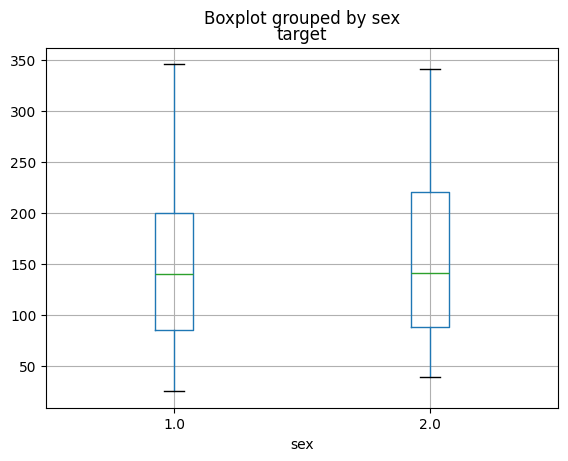

In [4]:
df.boxplot(column="target", by="sex")

Both boxes are very similar, however the box for sex `1` looks like it has slightly lower values (As seen by Q1 and Q3). 

Out of curisoity, let's see some simple stats for each `sex` value.

In [5]:
df.groupby("sex")["target"].describe()

,count,mean,std,min,25%,50%,75%,max
sex,,,,,,,,
1.0,235.0,149.021277,75.905781,25.0,85.5,140.0,200.0,346.0
2.0,207.0,155.666667,78.453313,39.0,88.0,141.0,220.5,341.0


The table above does show that the mean for sex `1` is slightly lower than sex `0`. This raises, the question, is this difference statistically significant?

We now have two groups, in which we want to check that the mean in one is **strictly lower** than the mean in the other. This is a perfect scenario for using a **one tailed t-test** to verify this. We can formulate the above problem thus:

**Hypotheses**
- $ H_0: \mu_1 \geq \mu_2 $ (Group 1 has the same or higher average `target` value)
- $ H_a: \mu_1 < \mu_2 $ (Group 1 has a lower average `target` value)

We shall use an alpha value of 0.05 to determine significance, as it represents a 5% risk of concluding that a difference exists when there is none (Type I error). This is a commonly accepted threshold in hypothesis testing

$$ alpha = 0.05 $$

Create the groups for each `sex` value.

In [6]:
group_1 = df[df["sex"] == 1]["target"]
group_2 = df[df["sex"] == 2]["target"]

Before we perform the hypothesis testing, it is important to highlight some key assumptions:
1. **Independence**
    - Observations must be independant of one another. This assumption is reasonably satisfied with this dataset as each observation represents a unique individual. 
3. **Normality**
    - The target values within each group (`target` column in this case) should be approximately normally distributed. Since each group contains 200+ observations (as seen above), the *Central Limit Theorem* suggests that the sampling distribution of the mean will be approximately normal, even if the underlying data is not perfectly normal.
5. **Homoscedacity**
    - Both groups have a similar variance.

### Validating Assumptions

For completeness, the above assumptions will be tested.

#### Independence

As stated above, this assumption is reasonably satisfied.

#### Normality

There are many methods of validating the normality of groups. For this example, we shall use a **Q-Q plot** (quantile-quantile plot). A Q-Q plot compares the quantiles of the sample data against the quantiles of a standard normal distribution. If the data is normally distributed, the points will approximately lie on a straight 45 degree line.

Interpretation:
- Points on the line -> data follows a normal distribution
- Points curving away at the ends -> heavy tails (kurtosis) or skew
- Systematic upward or downward bends -> skewness (left or right)

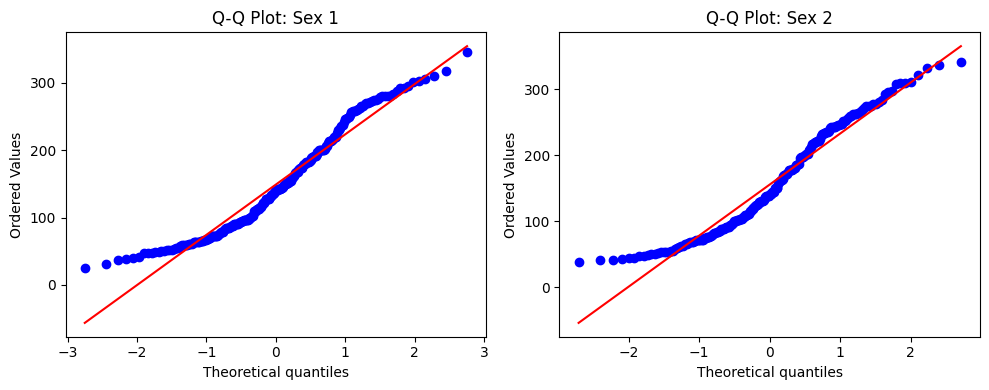

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
stats.probplot(group_1, dist="norm", plot=axs[0])
axs[0].set_title("Q-Q Plot: Sex 1")

stats.probplot(group_2, dist="norm", plot=axs[1])
axs[1].set_title("Q-Q Plot: Sex 2")
plt.tight_layout()
plt.show()

Normality Observations:

- In general, the data points follow the straight 45 degree line, indicating approximate normality.
- Towards the lower end (~ -3), the points curve upwards away from the line. However, since this pattern is subtle and consistent across both groups, it likely does not meaningfully violate the normality assumption—especially considering the sample size and the robustness of the t-test.

Ideally, we would like to see a closer adherence to the 45 degree line throughout. However, for the purpose of this example, we can accept that the normality assumption is reasonably met.

#### Homoscedacity

Homoscedacity can be tested via visual inspection, or using statistical tests. We shall perform one of each:
1. Boxplot inspection
2. Levene test

**Boxplot Inspection**
  
Firstly, we return to the boxplot plotted previously to perform a visual inspection of the variance between the groups.

<Axes: title={'center': 'target'}, xlabel='sex'>

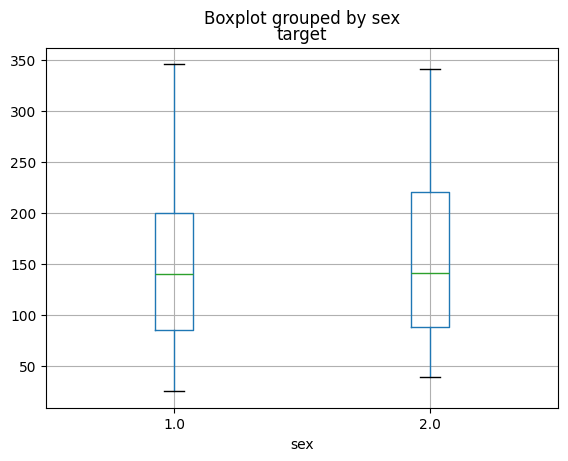

In [8]:
df.boxplot(column="target", by="sex")

Boxplot Observations:
- The IQR for sex `1` is slightly smaller than for sex `2`, indicating a somewhat tighter concentration of middle 50% values in sex `1`.
- The range represented by the whiskers for sex `1` is slightly larger than sex `2`, suggesting that while the core data spread is tighter, the overall spread (including potential outliers) is wider.

**Levene's Test**

The Levene test tests the null hypothesis that all samples are from populations with equal variance.

In [9]:
levene_stat, levene_p_stat = levene(group_1, group_2)
print(f"Levene's test statistic: {levene_stat:.4f}")
print(f"p-value: {levene_p_stat:.4f}")

Levene's test statistic: 0.6426
p-value: 0.4232


Levene's Observations:
- A Levene’s test statistic value of 0.6426 indicates that the variance differences between the groups are small relative to the variability within each group. This suggests the groups have similar variances.
- A p-value of 0.4232 is larger than our alpha of 0.05, so we fail to reject the null hypothesis of equal variances.

The assumption of homoscedacity holds for this dataset.

#### Validating Assumptions - Conclusion

Considering the above results, all key assumptions have been reasonably met: independence, normality (supported by the Q-Q plots), and homoscedasticity (confirmed by boxplot inspection and Levene’s test). This supports the validity of the test conclusions.

### Hypothesis Testing

We shall now use `scipy` to perform a two-tailed t-test. Scipy's `ttest_ind` returns two values:
1. `t-statistic`: How far the sample means are, relative to the variability in the data (larger = more significance)
2. `pvalue`: Probability in oberserving a difference at least as large as the one seen in the data

In [10]:
# equal_var=False performs Welch's t-test which is more robust to different population variances 
result = ttest_ind(group_2, group_1, equal_var=False)
t_stat, p_two_tailed, df = result.statistic, result.pvalue, result.df

As we want to perform a one-tailed t-test, we need to divide the `p` value by two.

In [11]:
if t_stat > 0:
    # t in the expected direction (group1 < group2)
    p_one_tailed = p_two_tailed / 2
else:
    p_one_tailed = 1 - (p_two_tailed / 2)

We can now examine the results:

In [12]:
print(f"t-statistic: {t_stat:.4f}")
print(f"One-tailed p-value: {p_one_tailed:.4f}")

t-statistic: 0.9022
One-tailed p-value: 0.1837


Considering the above results:
- A *t-statistic* value of 0.9022 suggests that the groups means are less than 1 standard error apart. This is not strong evidence that there is a difference.
- A *p-value* of 0.1837 is larger than our alpha of 0.05

In conclusion, based off of the above one-tailed t-test we **fail** to reject the **null** hypothesis as there is insignificant evidence to conclude that a sex of `1` results in a lower `target` value than a sex of `2`.

We can visually represent the one-tailed t-test results. The curve shows the t-distribution with the degrees of freedom calculated from our data.

- The red shaded area on the left tail represents the rejection region for our test at the chosen significance level (alpha=0.05). As our alternative hypothesis is that Group 1’s mean is less than Group 2’s mean, the critical region is in the left tail of the distribution.
- The vertical dashed line indicates the observed t-statistic from our test.

Interpretation:

- If the observed t-statistic falls within the shaded rejection region (i.e., to the left of the critical value), we reject the null hypothesis and conclude that there is statistically significant evidence that Group 1 has a lower mean than Group 2.
- If the t-statistic falls outside the shaded region, we fail to reject the null hypothesis, meaning the data do not provide strong enough evidence to support the claim that Group 1’s mean is lower.

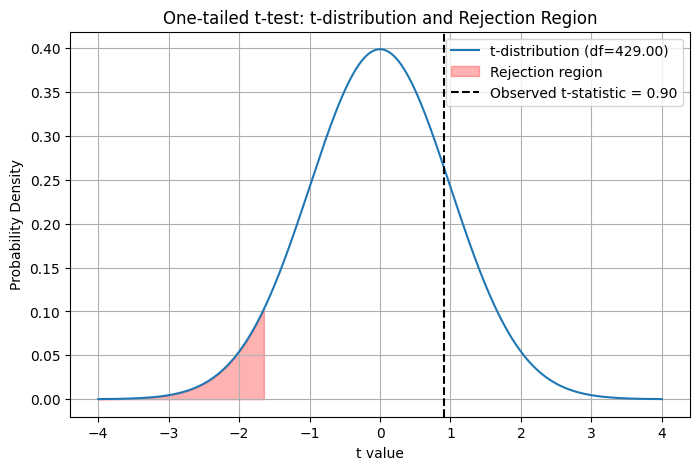

In [13]:
# Parameters
alpha = 0.05

x = np.linspace(-4, 4, 1000)
y = t.pdf(x, df)

# Critical t-value for one-tailed test (left tail)
t_crit = t.ppf(alpha, df)

plt.figure(figsize=(8, 5))
plt.plot(x, y, label=f't-distribution (df={df:.2f})')

# Shade rejection region (left tail)
x_fill = np.linspace(-4, t_crit, 100)
# alpha here denotes transparency, not significance level
plt.fill_between(x_fill, 0, t.pdf(x_fill, df), color='red', alpha=0.3, label='Rejection region')

# Mark observed t-statistic
plt.axvline(t_stat, color='black', linestyle='--', label=f'Observed t-statistic = {t_stat:.2f}')

plt.title('One-tailed t-test: t-distribution and Rejection Region')
plt.xlabel('t value')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()

Since the t-statistic lies well outside the left-tail rejection region (it is positive, not sufficiently negative), and the p-value is greater than our alpha of 0.05, we fail to reject the null hypothesis.

## Two-tailed t-test

We will use the `breast_cancer` dataset for an example. The target is a whether or not a tumor is cancerous. We will examine if there is a difference in the target based of off `mean radius`. More formally:
- Do malignant and benign turmors differ in mean radius?

In reality, we might reasonably expect malignant tumors to have a larger mean radius than benign ones, based on prior clinical knowledge. However, for the purpose of demonstrating a two-tailed t-test, we proceed as if we had no prior directional hypothesis, and simply test whether there is any difference in mean radius between the two groups.

In [14]:
dataset = datasets.load_breast_cancer(as_frame=True)
df = dataset.frame
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


We can formulate the problem as thus:

**Hypotheses**
- $ H_0: \mu_1 = \mu_2 $ (Malignant and benign tumors have the same `mean radius`)
- $ H_a: \mu_1 \neq \mu_2 $ (The `mean radius` differs between malignant and benign tumors,)

Again, we shall use an alpha value of 0.05 to determine significance.

$$ alpha = 0.05 $$

Create the test groups.

In [15]:
group_0 = df[df["target"] == 0]["mean radius"] # malignant
group_1 = df[df["target"] == 1]["mean radius"] # benign

### Validating assumptions

The two-tailed t-test has the same core assumptions as the one-tailed. Again, we shall attempt to validate each one.

#### Independence

As stated above, this assumption is reasonably satisfied.

#### Normality

Plot the Q-Q plot for each group.

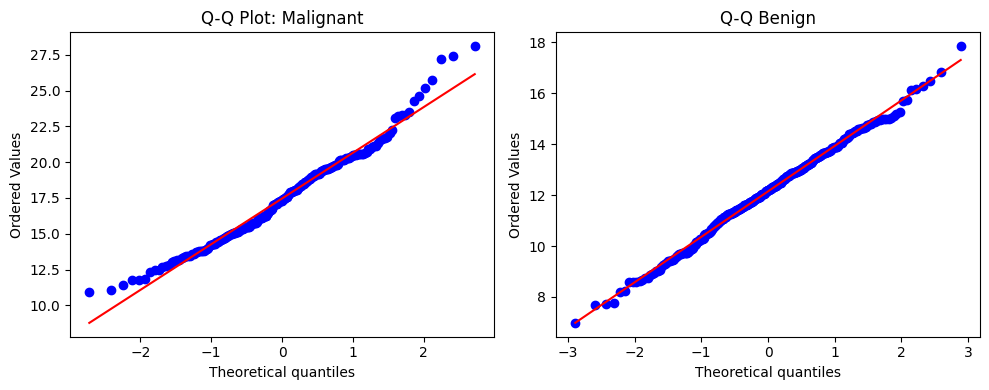

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
stats.probplot(group_0, dist="norm", plot=axs[0])
axs[0].set_title("Q-Q Plot: Malignant")

stats.probplot(group_1, dist="norm", plot=axs[1])
axs[1].set_title("Q-Q Benign")
plt.tight_layout()
plt.show()

Normality Observations:

- In general, the data points closely follow the 45 degree reference line, indicating approximate normality for both groups.
- This pattern is especially pronounced for the benign tumor group.
- For the malignant tumor group, there is a slight deviation from the line at the ends, suggesting a mild departure from normality in the tails.

Overall, the Q-Q plots suggest that the assumption of normality is reasonably satisfied for both groups, with only minor deviations that are unlikely to substantially impact the validity of the t-test.

#### Homoscedacity

The same tests will be performed again.

**Boxplot inspection**

<Axes: title={'center': 'mean radius'}, xlabel='target'>

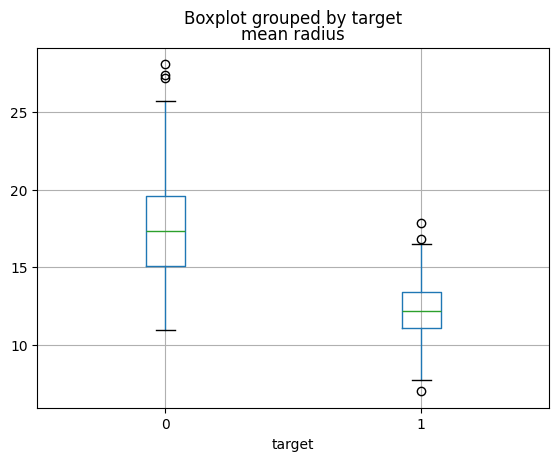

In [17]:
df.boxplot(column="mean radius", by="target")

Boxplot observations:
- The boxplots clearly show that the two groups have significantly different variances, with the benign tumors exhibiting a smaller spread in mean radius.
- Malignant tumors (class 0) tend to have more outliers, which are generally larger than the group mean, indicating greater variability and occasional extreme values compared to benign tumors.

**Levene's test**

In [18]:
levene_stat, levene_p_stat = levene(group_0, group_1)
print(f"Levene's test statistic: {levene_stat:.4f}")
print(f"p-value: {levene_p_stat:.4f}")

Levene's test statistic: 90.4771
p-value: 0.0000


Levene's observations:
- A Levene’s test statistic value of 90.48 indicates that the variance differences between the groups are large relative to the variability within each group. This suggests the groups have different variances.
- A p-value of < 0.001 is much smaller than our alpha of 0.05, so we reject the null hypothesis of equal variances.

#### Validating Assumptions - Conclusion

Considering the above results, the assumptions of independence and normality were verified. However, the assumption of equal variances has been violated, as indicated by both the boxplot inspection and Levene’s test results. Going forward, we will use Welch’s t-test, which is robust to unequal variances, to compare the group means.

### Hypothesis Testing

We shall now perform the two-tailed t-test.

In [19]:
# equal_var=False performs Welch's t-test which is more robust to different population variances 
result = ttest_ind(group_2, group_1, equal_var=False)
t_stat, p_two_tailed, df = result.statistic, result.pvalue, result.df

print(f"t-statistic: {t_stat:.4f}")
print(f"One-tailed p-value: {p_two_tailed:.4f}")

t-statistic: 26.3161
One-tailed p-value: 0.0000


Considering the above results:
- A *t-statistic* value of 26.3161 suggests that the groups means are very far apart. This is strong evidence that there is a difference.
- A *p-value* of < 0.0001 is much less than our alpha of 0.05

In conclusion, based off of the above two-tailed t-test we **reject** the **null** hypothesis as there is statistically significant evidence to conclude that the `mean radius` differs between malignant and benign tumors. 

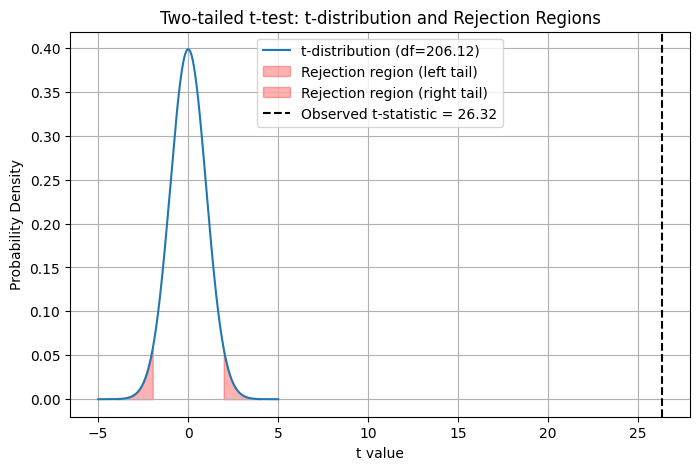

In [20]:
# Parameters
alpha = 0.05

# even though the extreme t-stat, plotting larger than [-5, 5] just looks silly
x = np.linspace(-5, 5, 1000)
y = t.pdf(x, df)

# Critical t-value for one-tailed test (left tail)
t_crit_low = t.ppf(alpha / 2, df)
t_crit_high = t.ppf(1 - alpha / 2, df)

plt.figure(figsize=(8, 5))
plt.plot(x, y, label=f't-distribution (df={df:.2f})')

# Shade left tail rejection region
x_fill_left = np.linspace(-4, t_crit_low, 100)
plt.fill_between(x_fill_left, 0, t.pdf(x_fill_left, df), color='red', alpha=0.3, label='Rejection region (left tail)')

# Shade right tail rejection region
x_fill_right = np.linspace(t_crit_high, 4, 100)
plt.fill_between(x_fill_right, 0, t.pdf(x_fill_right, df), color='red', alpha=0.3, label='Rejection region (right tail)')

# Mark observed t-statistic
plt.axvline(t_stat, color='black', linestyle='--', label=f'Observed t-statistic = {t_stat:.2f}')

plt.title('Two-tailed t-test: t-distribution and Rejection Regions')
plt.xlabel('t value')
plt.ylabel('Probability Density')
plt.legend(loc="upper center")
plt.grid(True)
plt.show()

This graph presents an intersting case where the t-statistic is so extremely large, it is difficult to effectively plot. The uppper rejection region *technically* spans from [t_crit_upper, +infinity], so therefore out t-statistic *does* infact lie within the upper rejection region, therefore showing that we reject the null hypothesis. Re-creating the above plot, for x-values closer to the t-statistic should give us a better view.

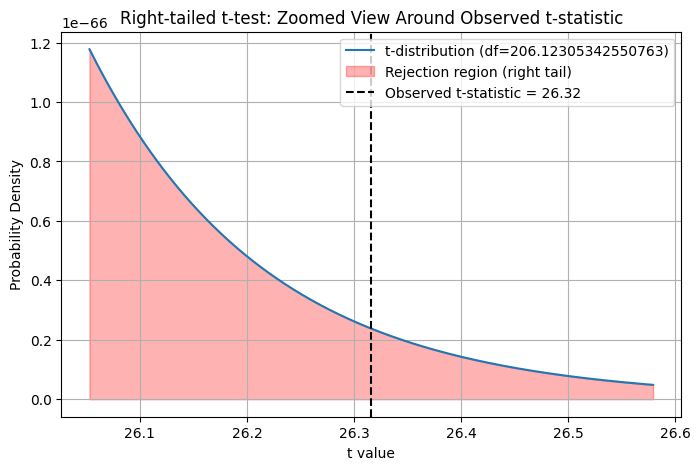

In [21]:
# Define x range ±1% around t_stat
x_min = t_stat * 0.99
x_max = t_stat * 1.01
x = np.linspace(x_min, x_max, 500)
y = t.pdf(x, df)

plt.figure(figsize=(8, 5))
plt.plot(x, y, label=f't-distribution (df={df})')

# # Shade right tail rejection region (from critical t to infinity, here limited to plot range)
plt.fill_between(x, 0, t.pdf(x, df), color='red', alpha=0.3, label='Rejection region (right tail)')

# Mark critical t-value and observed t-statistic
plt.axvline(t_stat, color='black', linestyle='--', label=f'Observed t-statistic = {t_stat:.2f}')

plt.title('Right-tailed t-test: Zoomed View Around Observed t-statistic')
plt.xlabel('t value')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()

## Summary

This notebook explored both one-tailed and two-tailed t-tests as methods to compare group means, and evaluate the statistical significance.

- The t-test assumptions independance, normality and homoscedacity (equal variance), were validated. When the equal variance assumption is violated, as shown in the cancer dataset, Welch’s t-test (equal_var=False) provides a more reliable alternative to the Student’s t-test.
- Interpreting the t-statistic and p-value together allows us to make informed decisions about rejecting or failing to reject the null hypothesis.

Understanding these principles is foundational for more advanced statistical techniques